In [1]:
from transformers import pipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:

from huggingface_hub import login
import os

hf_token = os.getenv("HUGGINGFACEHUB_API_TOKEN")

login(hf_token)


### GPT-2 Model

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_pipe = pipeline("text-generation", model=gpt2_model, tokenizer=gpt2_tokenizer)

Device set to use cpu


### BERT Model

In [5]:
from transformers import BertTokenizer, BertForMaskedLM

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForMaskedLM.from_pretrained("bert-base-uncased")
bert_pipe = pipeline("fill-mask", model=bert_model, tokenizer=bert_tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


### Facebook(OPT-350M) Model

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

facebook_tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")
facebook_model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m")
facebook_pipe = pipeline("text-generation", model=facebook_model, tokenizer=facebook_tokenizer)

Device set to use cpu


### Text Completion

In [24]:
import gradio as gr

def generate_outputs(text):
    gpt2_out = gpt2_pipe(text, max_length=30)[0]["generated_text"] # type: ignore
    facebook_out = facebook_pipe(text, max_length=30)[0]["generated_text"] # type: ignore

    if "[MASK]" not in text:
        bert_input = text + " [MASK]."
    else:
        bert_input = text
    bert_out = bert_pipe(bert_input)[0]["sequence"] # type: ignore
    return gpt2_out, bert_out, facebook_out

iface = gr.Interface(
    fn=generate_outputs,
    inputs=gr.Textbox(label="Enter a sentence"),
    outputs=[gr.Textbox(label="GPT-2 Completion"), gr.Textbox(label="BERT Completion"), gr.Textbox(label="Facebook Completion")],
    title="GPT-2 vs BERT vs Facebook"
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


### Visualizing BERT Attention Weights 

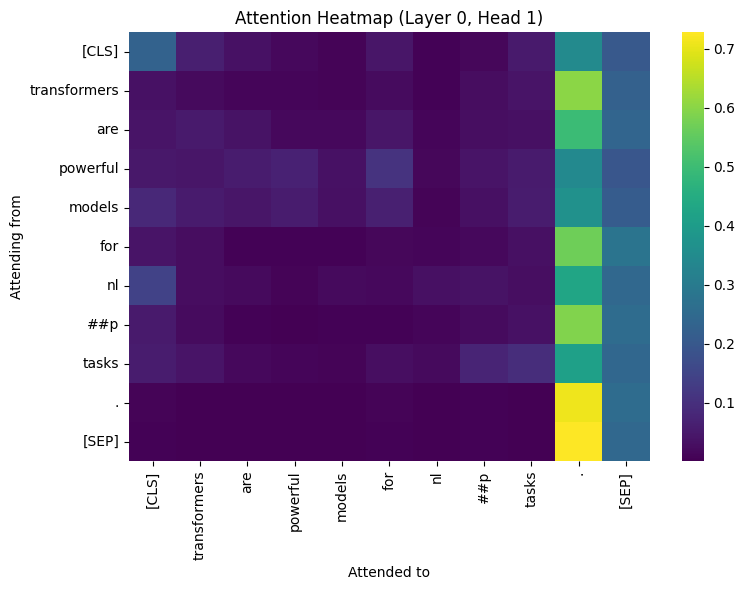

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

text = "Transformers are powerful models for NLP tasks."
inputs = bert_tokenizer(text, return_tensors="pt")

outputs = bert_model(**inputs, output_attentions=True)
attentions = outputs.attentions

layer = -1   # Last layer
head = 0     # First attention head

attention_matrix = attentions[layer][0, head].detach().numpy()

tokens = bert_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

plt.figure(figsize=(8, 6))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title(f"Attention Heatmap (Layer {layer+1}, Head {head+1})")
plt.xlabel("Attended to")
plt.ylabel("Attending from")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Visualizing GPT Attention Weights 

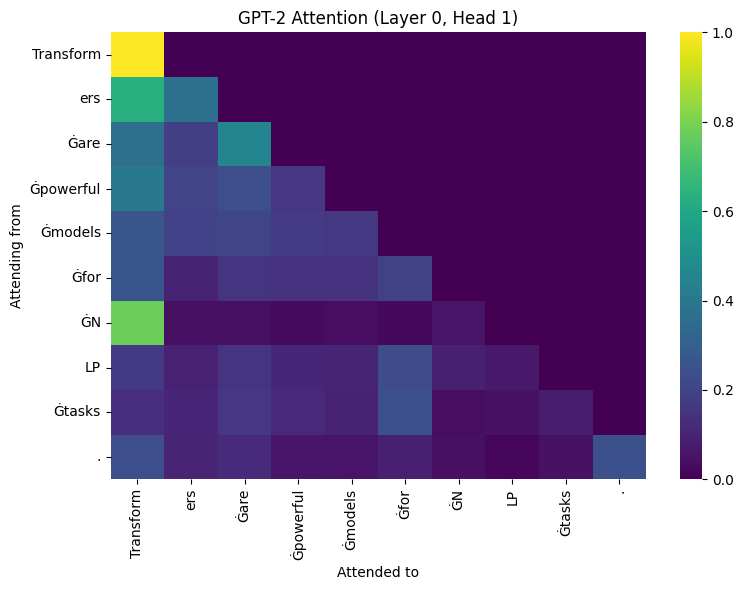

In [ ]:
import torch

text = "Transformers are powerful models for NLP tasks."
inputs = gpt2_tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = gpt2_model(**inputs, output_attentions=True)
attentions = outputs.attentions  # List: [layer1_attn, layer2_attn, ..., layer12_attn]

layer = -1  # Last layer
head = 0    # First head
attention_matrix = attentions[layer][0, head].numpy()  # (seq_len, seq_len)

tokens = gpt2_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

plt.figure(figsize=(8, 6))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title(f"GPT-2 Attention (Layer {layer+1}, Head {head+1})")
plt.xlabel("Attended to")
plt.ylabel("Attending from")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
